In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval
plt.style.use('default')

In [0]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [0]:
%run ./utils_stats_modeling

In [0]:
%run ./utils_visualization

In [0]:
# File location and type
file_location = "/FileStore/tables/daily_citibike_demand_2013_06_to_2022_02.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df)
ride_df = df.toPandas()
ride_df['starttime'] = pd.to_datetime(ride_df['starttime'])
ride_df.set_index('starttime', inplace=True)

In [0]:
ride_df.head()

,station_id,lat,long,ride_count,year,time
starttime,,,,,,
2013-06-01,72.0,40.767272,-73.993929,40,2013,2013-06-01
2013-06-01,79.0,40.719116,-74.006667,61,2013,2013-06-01
2013-06-01,82.0,40.711174,-74.000165,6,2013,2013-06-01
2013-06-01,83.0,40.683826,-73.976323,32,2013,2013-06-01
2013-06-01,116.0,40.741776,-74.001497,53,2013,2013-06-01


In [0]:
daily_rides = ride_df[['ride_count']].resample('1D').sum()
daily_rides['ride_count'] = daily_rides['ride_count'].replace(to_replace=0, method='bfill')

In [0]:
test_start = '2021-01-01'
daily_rides['future'] = (daily_rides.index >= test_start).astype('int')

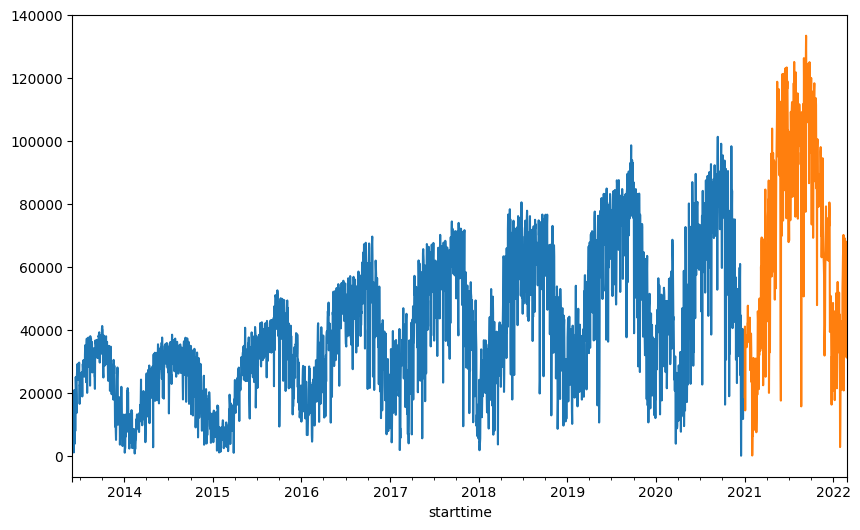

In [0]:
plt.figure(figsize=(8,5))
daily_rides.loc[daily_rides.future == 0, 'ride_count'].plot()
daily_rides.loc[daily_rides.future == 1, 'ride_count'].plot()
plt.show()

#### Naive Model

In [0]:
# Inserting a time period track for our naive models
daily_rides.insert(0, 't', range(len(daily_rides)))

In [0]:
# train test split
X_train = daily_rides.loc[daily_rides.future == 0, 't'].values.reshape(-1, 1)
X_test = daily_rides.loc[daily_rides.future == 1, 't'].values.reshape(-1, 1)

y_train = daily_rides.loc[daily_rides.future == 0, 'ride_count'].values
y_test = daily_rides.loc[daily_rides.future == 1, 'ride_count'].values

In [0]:
# Naive Model: using the average of the train data
y_preds = daily_rides.loc[daily_rides.future == 0, 'ride_count'].mean()

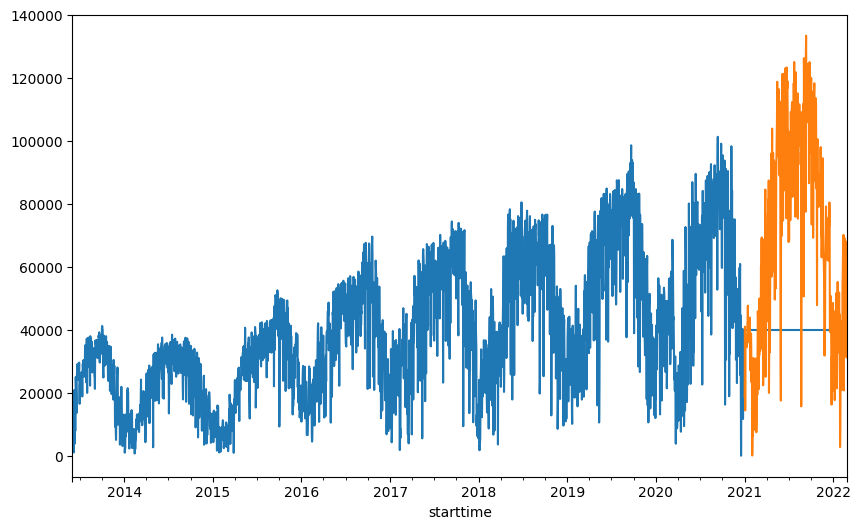

In [0]:
# Plot the Prediction
plt.figure(figsize=(8,5))
daily_rides.loc[daily_rides.future == 0, 'ride_count'].plot()
daily_rides.loc[daily_rides.future == 1, 'ride_count'].plot()
plt.hlines(y=y_preds,
          xmin=daily_rides.loc[daily_rides.future == 1, 'ride_count'].index[0],
          xmax=daily_rides.loc[daily_rides.future == 1, 'ride_count'].index[-1])
plt.show();

In [0]:
# Evaluation Metric
y_preds = [y_preds] * len(y_test)
results = evaluation_metrics(y_test, y_preds, "Naive Baseline")

    Evaluation of Naive Baseline Model
****************************************************
Mean Absolute Error =  36440.28964153668
Median Absolute Error =  32477.5
Mean Squared Error =  2016352947.2480602
Root Mean Squared Error =  44903.81884927005
R2 Score =  -0.8465026442507446
MAE to Mean Ratio Percentage= 51.585023563002586 %
****************************************************


Not a good performance at all as expected!

### Linear Regression Model

In [0]:
# Naive Model: Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)
y_trend_lr = lr.predict(X_train)

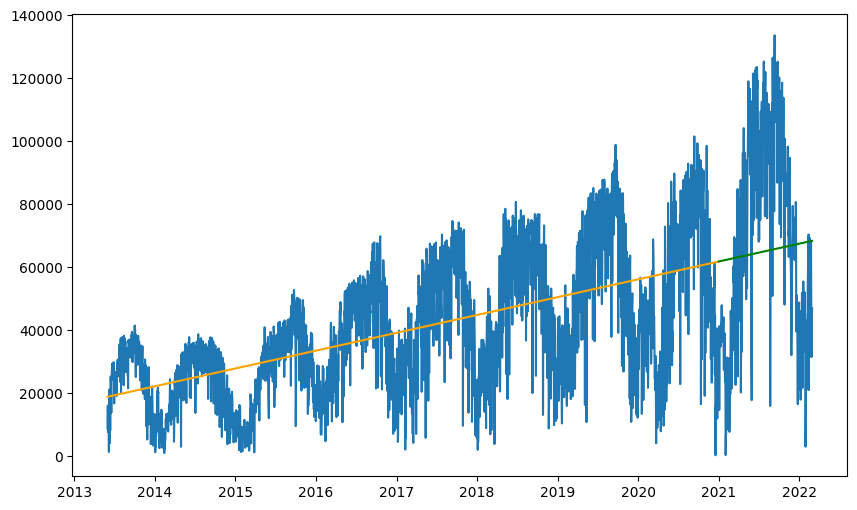

In [0]:
# Plot results
plt.figure(figsize=(8,5))
plt.plot(daily_rides['ride_count'])
plt.plot(daily_rides.loc[daily_rides.future == 0].index, y_trend_lr, color='orange')
plt.plot(daily_rides.loc[daily_rides.future == 1].index, y_preds_lr, color='green')
plt.show()

In [0]:
# Evaluation Metric
results = evaluation_metrics(y_test, y_preds_lr, "Linear Regression")

    Evaluation of Linear Regression Model
****************************************************
Mean Absolute Error =  29352.73590321816
Median Absolute Error =  30468.11858462944
Mean Squared Error =  1115126073.1484
Root Mean Squared Error =  33393.503457235514
R2 Score =  -0.021191872956432878
MAE to Mean Ratio Percentage= 41.551853404594645 %
****************************************************


The linear regression is slightly better than the average baseline model. As can be observed, it only can capture the upward trend of data without any more controls.

These nahive models give us a good benchmark to compare our future models performance metrics against.

### ARIMA Model

In [0]:
# ARIMA model on daily data with 365 days seasonality period
# (based on the bike demand plots the yearly seasonality is observed)

seas_arima = ARIMA(daily_rides.loc[daily_rides.future == 0]['ride_count'], 
                   order = (1, 1, 1), seasonal_order=(0, 0, 0, 365))

baseline_sarima = seas_arima.fit()

In [0]:
# Making the Predictions
actuals = daily_rides.loc[daily_rides.future == 1]['ride_count']
preds = baseline_sarima.forecast(steps = len(daily_rides.loc[daily_rides.future == 1]))
# Model Evaluation
results = evaluation_metrics(actuals, preds, "ARIMA Yearly Seasonality")

    Evaluation of ARIMA Yearly Seasonality Model
****************************************************
Mean Absolute Error =  42668.301586566566
Median Absolute Error =  40610.10392726079
Mean Squared Error =  2722385910.2919846
Root Mean Squared Error =  52176.488098491114
R2 Score =  -1.493061935851001
MAE to Mean Ratio Percentage= 60.4014228313779 %
****************************************************


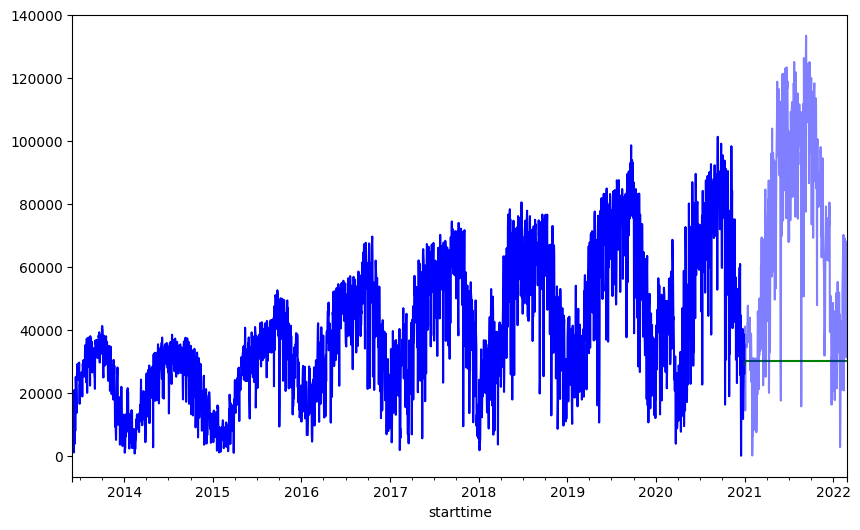

In [0]:
# Visualizing the forecasting
plot_results(daily_rides, preds, False)

Very poor performance is observed. The daily data with yearly seasonality was not a good approach. More investigation is needed to find out the more accurate seasonality pattern of the data for which Autocorrelation is a very useful tool to use.

In [0]:
# File location and type
file_location = "/FileStore/tables/agg/hourly_citibike_demand_2013_06_to_2016_12.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df)
hourly_rides = df.toPandas()
hourly_rides['starttime'] = pd.to_datetime(hourly_rides['starttime'])
hourly_rides.set_index('starttime', inplace=True)

In [0]:
hourly_ride_df = hourly_rides[['ride_count']].resample('1H').sum()
hourly_ride_df['ride_count'] = hourly_ride_df['ride_count'].replace(to_replace=0, method='bfill')

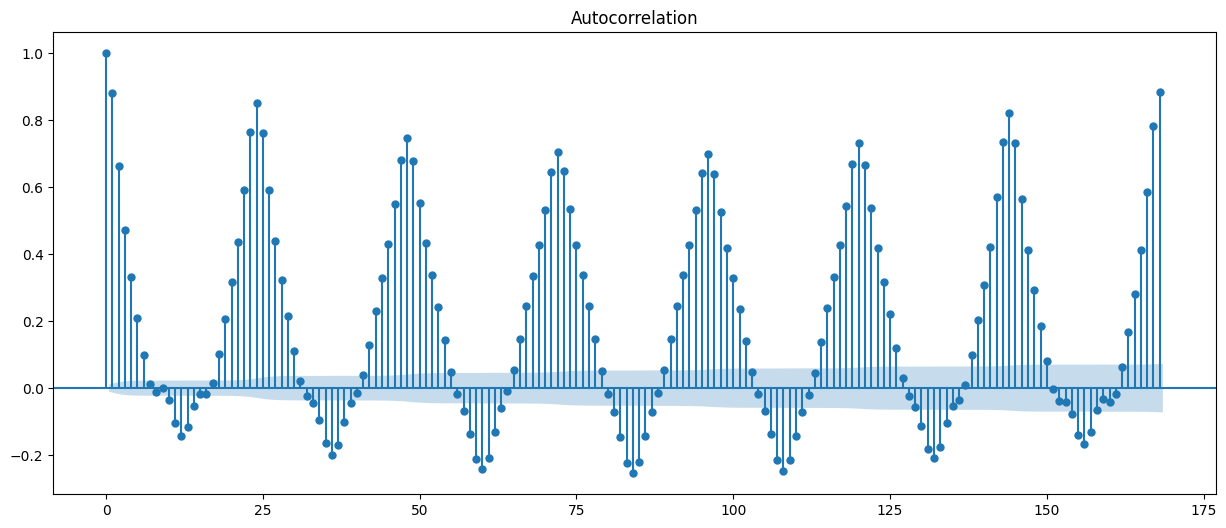

In [0]:
fig, ax = plt.subplots(figsize=(15,6))
tsa.plot_acf(hourly_ride_df['ride_count'], lags=7*24, ax=ax);

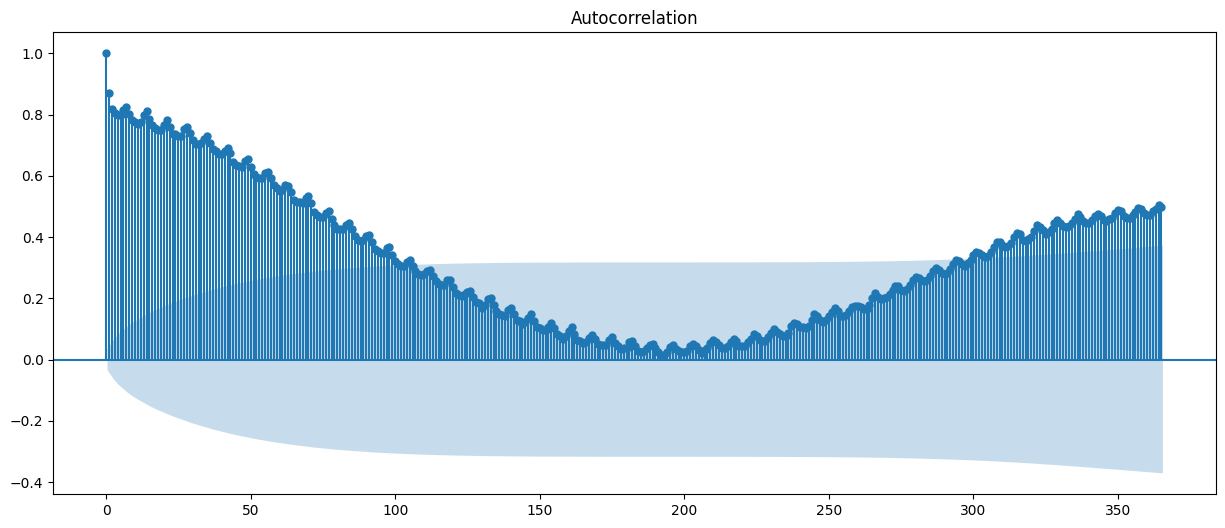

In [0]:
fig, ax = plt.subplots(figsize=(12,5))
tsa.plot_acf(daily_rides['ride_count'], lags=365, ax=ax);

According to the Autocorrelation plot we can see there is a clear yearly seasonality since the autocorrelation values going back up when the moving window is getting closer to 365 days. 

With taking a closer look, we can notice the smaller waves on top of the plot which have the periodicity of 7 points which equals a week. So in modeling we need to coonsider both seasonality types

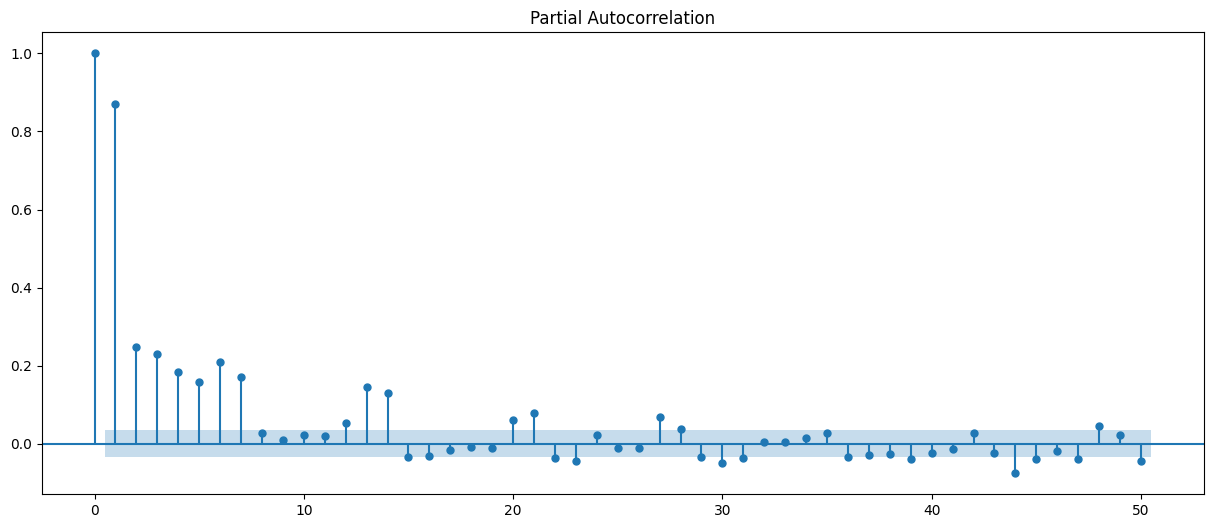

In [0]:
fig, ax = plt.subplots(figsize=(12,5))
tsa.plot_pacf(daily_rides['ride_count'], method='ywm', lags=50, ax=ax);

In the partial autocorrelation plot, we can see a clear weekly seasonality period

Based on the obseravtions from both autocorrelation and partial autocorrelation plots moving from daily to weekly seasonality is deffenitly a very good idea. So next the weekly frequency will be used to forecast bike ride demand

### Weekly Data

In [0]:
# Downsampling from daily to weekly frequency
weekly_rides = daily_rides.resample('W-SUN').sum().drop('future', axis=1)
weekly_rides.drop('t', axis=1, inplace=True)

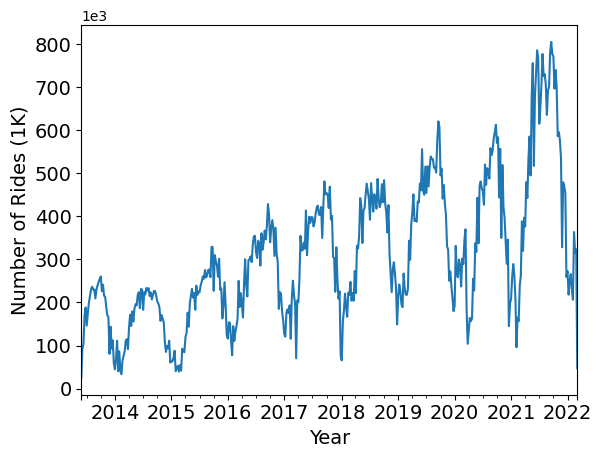

In [0]:
fig, ax = plt.subplots();
weekly_rides['ride_count'].plot(ax=ax)
ax.grid(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (1K)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_xlabel('Year', fontsize=14);
# A lot cleaner than the daily data

In [0]:
# Making time stamps for future
weekly_rides['future'] = (weekly_rides.index >= test_start).astype('int')

In [0]:
# changing the bike demand scale to logarithmic scale (this approach is reported to give better results on some data)
weekly_rides['ride_count_log'] = weekly_rides['ride_count'].apply(lambda x: np.log(x))

In [0]:
# Train test splits
train_weekly = weekly_rides[weekly_rides['future'] == 0]['ride_count_log']
test_weekly = weekly_rides[weekly_rides['future'] == 1]['ride_count_log']

In [0]:
# Using D-fuller test to see the data is stationary or not
dickey_fuller(weekly_rides[weekly_rides['future'] == 0]['ride_count'], False, True)

Data is stationary. P-value of 0.0025
Out[44]: (True, 0.002460993634860957)

The p-value suggests the bike ride data stationary. On some data, however, we can still work with the difference of data, specially the ones with strong trend, and get rid of trend and off course have much more stationary data.

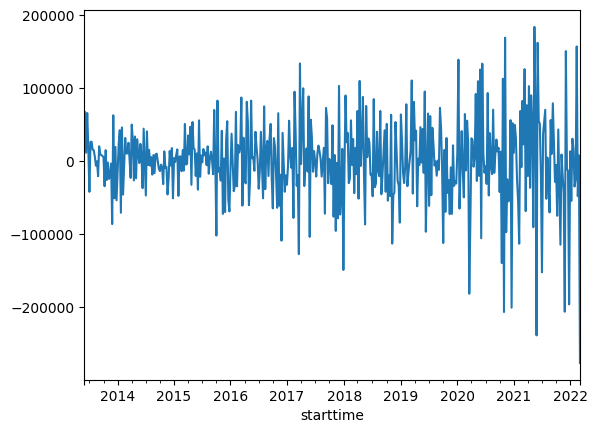

In [0]:
# Plotting the first diffrential of original data 
weekly_rides['1st_dif'] = weekly_rides['ride_count'].diff()
weekly_rides['1st_dif'].plot();

The first differential of original data clearly shows much more stationary data, but also it shows the increasing variance of data which is not ideal for ARIMA based models. This suggests the use of log based scale would be a good idea to get a more consistent variance. Now let's check the differencing of log scaled data

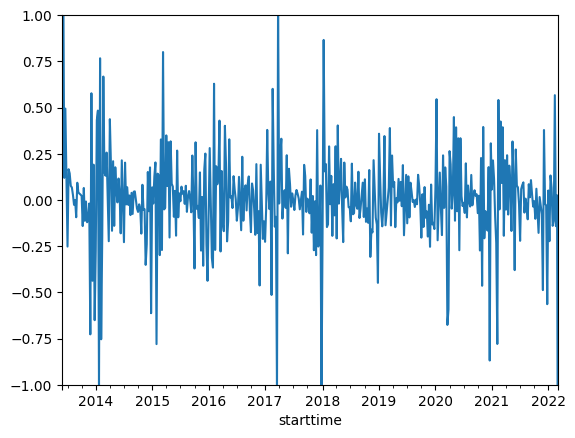

In [0]:
fig, ax = plt.subplots()
ax.set_ylim([-1, 1])
weekly_rides['ride_count_log'].diff().plot(ax=ax);

The differenc of log scaled data is clearly much more stationary than the differenc of original scale of data. This can be confirmed the very low p value obtained from dickey fuller test

In [0]:
dickey_fuller(weekly_rides[weekly_rides['future'] == 0]['ride_count_log'].diff().dropna(), False, True)

Data is stationary. P-value of 0.0000
Out[47]: (True, 1.14580309354703e-09)

# SARIMA Model

In [0]:
# SARIMA model with 52 weeks lag
weekly_model = SARIMAX(train_weekly, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit(disp=False)
# Generating a df to save weekly forecastings
y_weekly_pred = weekly_rides.loc[weekly_rides.future == 1].copy()
# Predictions
y_weekly_pred['weekly_pred_no_tune'] = weekly_model.forecast(steps = len(test_weekly))

In [0]:
results = evaluation_metrics(test_weekly, y_weekly_pred['weekly_pred_no_tune'], "Weekly SARIMA with 52 week")

    Evaluation of SARIMA with 52 week Model
****************************************************
Mean Absolute Error =  0.36940512740959414
Median Absolute Error =  0.29291107884465006
Mean Squared Error =  0.23645863580663598
Root Mean Squared Error =  0.4862701263769305
R2 Score =  0.30081089776988656
MAE to Mean Ratio Percentage= 2.8513094982358718 %
****************************************************


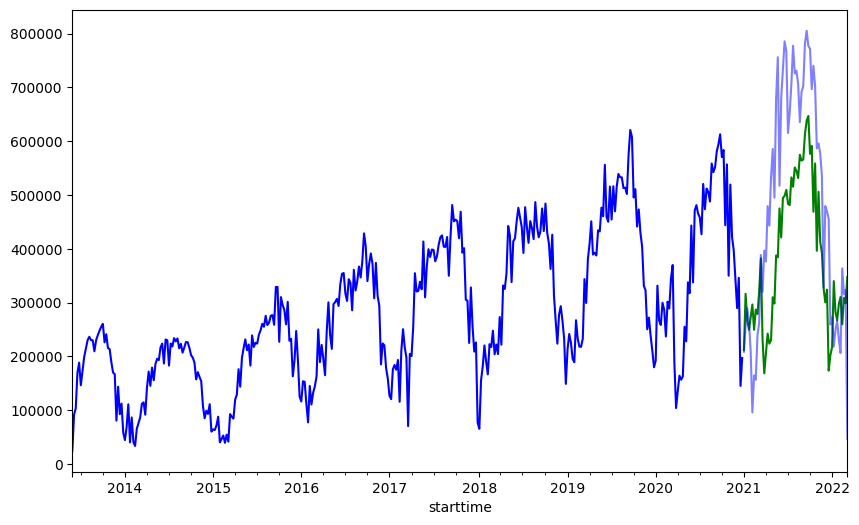

In [0]:
# Visualizing the results
plot_results(weekly_rides, y_weekly_pred['weekly_pred_no_tune'], True)

### Observation
This is a very good performance given there is still no grid search at this step. This indicates the data had strong weekly seasonlity

### Tunning Model
The performance of weekly data with yearly seasonlaity was very promising. With a gird search it can be possible to even improve the performance of the model. Since the original data was statinory we can keep "d" term for grid search eaitehr zero or one. For other terms (p and q and PDQ) we can first keep them at either 0 or one to see if these Substitutions can help or not to save time. If not we can increase the range.

In [0]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
best_ev = 0

for param in pdq:
    for param_seasonal in seasonal_pdq: 
        model = SARIMAX(train_weekly, order=param, seasonal_order=param_seasonal).fit(maxiter=1000, disp=False)
        
        y_ = model.forecast(steps = len(test_weekly))
        ev = metrics.explained_variance_score(np.exp(test_weekly), np.exp(y_))

        if ev > best_ev:
            best_ev = ev
            best_order = param
            best_s_order = param_seasonal

In [0]:
# Evaluate the new tunned model
weekly_model_tunned = SARIMAX(train_weekly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

y_weekly_pred['weekly_pred_tunned'] = weekly_model_tunned.forecast(steps = len(test_weekly))

# (0, 1, 1) and (0, 1, 1, 52) produced worth results for 2021 
# but better for 2022 projection 

In [0]:
results = evaluation_metrics(test_weekly, y_weekly_pred['weekly_pred_tunned'], "SARIMA with Grid Search")

    Evaluation of SARIMA with Grid Search Model
****************************************************
Mean Absolute Error =  0.20236754274310786
Median Absolute Error =  0.14150641339159797
Mean Squared Error =  0.12598093207717215
Root Mean Squared Error =  0.3549379270762314
R2 Score =  0.6274845513818241
MAE to Mean Ratio Percentage= 1.562004568816635 %
****************************************************


#### Awesome! The best model so far

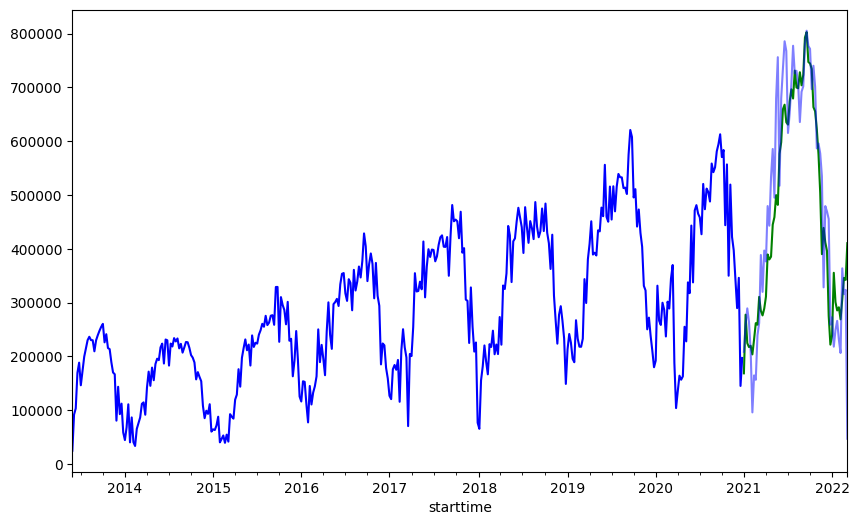

In [0]:
# visualization
plot_results(weekly_rides, y_weekly_pred['weekly_pred_tunned'], True)

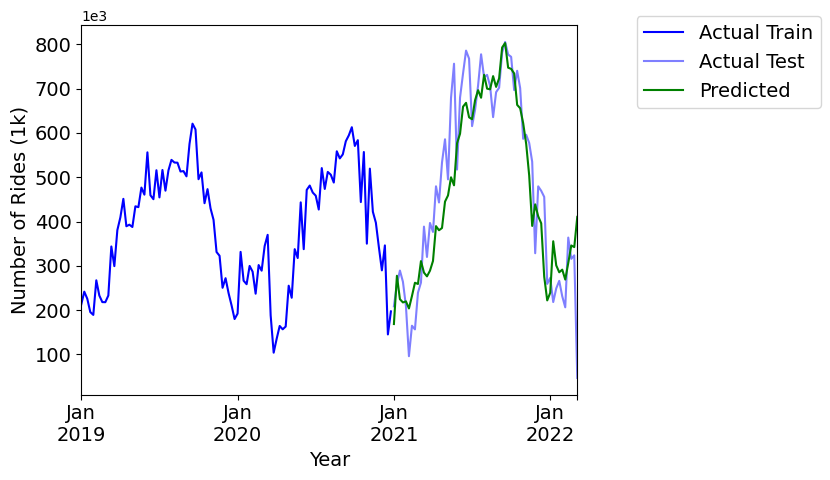

In [0]:
# Closer shot
fig, ax = plt.subplots()
past = weekly_rides[(weekly_rides['future'] == 0) & (weekly_rides.index > '12/31/2018')]
actual = weekly_rides[weekly_rides['future'] == 1]
projections = weekly_model_tunned.forecast(steps = len(test_weekly))
past['ride_count'].plot(ax=ax, color='blue')
actual['ride_count'].plot(ax=ax, color='blue', alpha=0.5)
np.exp(projections).plot(ax=ax, color='green')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (1k)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(['Actual Train', 'Actual Test', 'Predicted'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.minorticks_off()
ax.grid(False);

### Now let's forecast a year ahead with our best model

In [0]:
# Retraining the best model with the entire dataset and for a one-year forecast
weekly_model_tunned = SARIMAX(weekly_rides['ride_count_log'], order=(0, 0, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

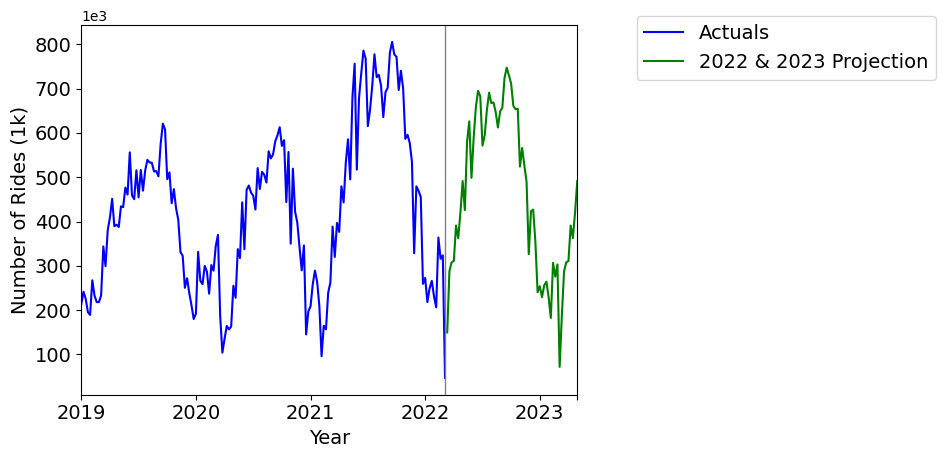

In [0]:
# Plot the one year forecast from March 2022 and to Feb 2023

fig, ax = plt.subplots()
actuals = weekly_rides[weekly_rides.index > '12/31/2019']
projections = weekly_model_tunned.forecast(steps = 60)
projections = np.exp(projections[projections.index > '02/28/2022'])
# Plot results
actuals['ride_count'].plot(ax=ax, color='blue')
projections.plot(ax=ax, color='green')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (1k)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(['Actuals', '2022 & 2023 Projection'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.axvline(x='02/28/2022', color='gray', linewidth=1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.minorticks_off()
ax.grid(False);

### Discussion and Conclusion

Providing accurate long-term forecasting is a very powerful strategy for businesses to take advantage of for better planning and taking proactive actions accordingly. In this project it was tried to provide a one-year forecasting for Citibike owned by Lyft Company in NYC for the next year while making sure the modeling was pretty accurate for previous years. 

The two most important aspects in demand forecasting are:

   - how accurate you can predict the future demand?
   - how far in future you can predict while still stay accurate?
   
To satisfy these business concerns I used a relatively long period for forecasting time while keeping the predictive performance pretty accurate.
    
    
    In the DB accelerator for demand forecasting there are a few models for the Citibike data. 
    Here I am going to compare the best model in DB solution with the best model here (both for overall forecasting):
    
    The best model in DB accelerator:
    RMSE: 2.37
    MSE: 5.63
    
    The best model here:
    RMSE: 0.355
    MSE: 0.126
    
As it can be seen, the are some significant improvements. One of the major reasons for the improvement is that I used the autocorrelation coefficients to discover hidden pattern of periodicity in data and then tried to consider that to model the seasonality as well. Also, this prediction is for one year while in DB it was for much shorter period. However, we used a weekly basis forecasting not hourly which is the major hint from autocorrelation. Also, beside the aggregated model, I modeled based on the neighborhood level aggregated data rather than individual stations with each neighborhood having their own model and tuned by a grid search independently from other models. This makes us more flexible in planning for each neighborhood separately by considering the demands for each specific neighborhood like adding more bike stations in that area if the demand is increasing. Another diffrentiatin from the original solution is using the most recent data for predicting future.

    
This is while I haven't used any of NYC weather data, callender data, NYC taxi ride data which was in my original plan but after seeing the good and reasonable performance of the models and also lack of time for X-challenge I decided not to include them. But if had more time, I would continue first with NYC taxi data which had very high correlation with Citibike ride data.